In [43]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [44]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(train_data.shape)
print(test_data.shape)
train_data.head()


(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


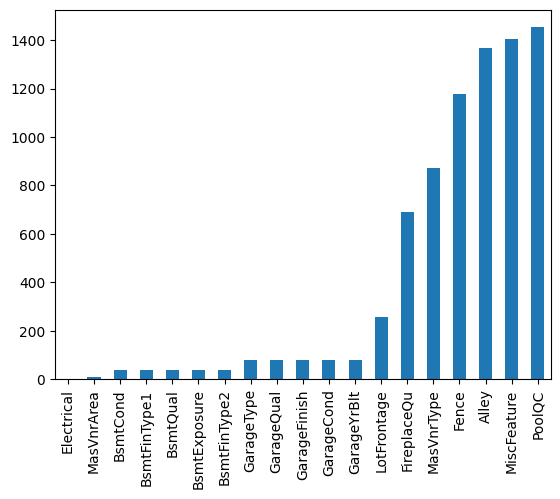

In [45]:
# Checking missing values
missing = train_data.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
numerical_features = train_data.select_dtypes(include=np.number)
train_data[numerical_features.columns] = train_data[numerical_features.columns].fillna(numerical_features.median())

In [46]:
categorical_features = train_data.select_dtypes(exclude=np.number)
for col in categorical_features.columns:
    train_data[col] = train_data[col].fillna(train_data[col].mode()[0])


In [47]:
train_data.isnull().sum().sum()

np.int64(0)

In [48]:
# Total Bathrooms (Full bath + Half bath)
train_data['TotalBathrooms'] = (train_data['FullBath'] + (0.5 * train_data['HalfBath']) +
                                train_data['BsmtFullBath'] + (0.5 * train_data['BsmtHalfBath']))
train_data['TotalSF'] = (train_data['TotalBsmtSF'] + train_data['1stFlrSF'] + train_data['2ndFlrSF'])
train_data['HouseAge'] = train_data['YrSold'] - train_data['YearBuilt']
train_data['RemodelAge'] = train_data['YrSold'] - train_data['YearRemodAdd']
train_data['IsNewHouse'] = (train_data['YearBuilt'] == train_data['GarageYrBlt']).astype(int)


In [49]:
# Convert categorical variables to dummy/one-hot encoding
train_data = pd.get_dummies(train_data)

In [50]:
X = train_data.drop(['SalePrice', 'Id'], axis=1)
y = train_data['SalePrice']

In [51]:
# Split Data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
# Define Models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": xgb.XGBRegressor(),
    "Support Vector Regressor": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor()
}

In [53]:
# Train and Evaluate Models
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    results[name] = rmse
    print(f"{name} RMSE: {rmse:.2f}")

Linear Regression RMSE: 29614.56
Ridge Regression RMSE: 29768.42


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.248e+11, tolerance: 6.967e+08
  model = cd_fast.enet_coordinate_descent(


Lasso Regression RMSE: 28262.48
Random Forest RMSE: 30019.42
Gradient Boosting RMSE: 27784.21
XGBoost RMSE: 27841.96
Support Vector Regressor RMSE: 88651.15
K-Nearest Neighbors RMSE: 46863.05


<ipython-input-54-4a23988db182>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=results_df, palette="viridis")


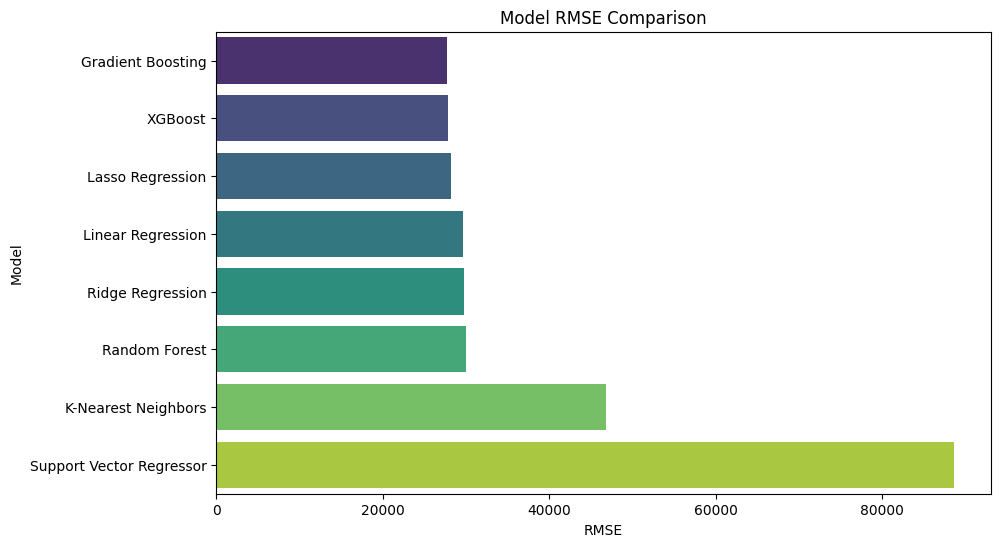

In [54]:
results_df = pd.DataFrame(list(results.items()), columns=['Model', 'RMSE']).sort_values(by='RMSE')

# Plot the results
plt.figure(figsize=(10,6))
sns.barplot(x='RMSE', y='Model', data=results_df, palette="viridis")
plt.title('Model RMSE Comparison')
plt.show()

In [55]:
# Step 5: Hyperparameter Tuning - Gradient Boosting
from sklearn.model_selection import GridSearchCV
gb_model = GradientBoostingRegressor()

gb_param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}

gb_grid_search = GridSearchCV(estimator=gb_model, param_grid=gb_param_grid,
                              scoring='neg_root_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

gb_grid_search.fit(X_train, y_train)

print("🔍 Best Parameters for Gradient Boosting:", gb_grid_search.best_params_)

# Step 6: Hyperparameter Tuning - XGBoost
xgb_model = xgb.XGBRegressor()

xgb_param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0]
}

xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid,
                               scoring='neg_root_mean_squared_error', cv=3, verbose=2, n_jobs=-1)

xgb_grid_search.fit(X_train, y_train)

print("🔍 Best Parameters for XGBoost:", xgb_grid_search.best_params_)


Fitting 3 folds for each of 81 candidates, totalling 243 fits
🔍 Best Parameters for Gradient Boosting: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}
Fitting 3 folds for each of 81 candidates, totalling 243 fits
🔍 Best Parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.7}


In [56]:
# Step 7: Compare Best Models
from sklearn.model_selection import cross_val_score
best_gb = GradientBoostingRegressor(**gb_grid_search.best_params_)
best_xgb = xgb.XGBRegressor(**xgb_grid_search.best_params_)

# Cross Validation Scores
gb_scores = cross_val_score(best_gb, X, y, scoring='neg_root_mean_squared_error', cv=5)
xgb_scores = cross_val_score(best_xgb, X, y, scoring='neg_root_mean_squared_error', cv=5)

print("\n✅ Gradient Boosting CV RMSE Mean:", -gb_scores.mean())
print("✅ XGBoost CV RMSE Mean:", -xgb_scores.mean())


✅ Gradient Boosting CV RMSE Mean: 25397.642394844337
✅ XGBoost CV RMSE Mean: 25461.998046875


In [57]:
#Step 8: Select Best Model
if -gb_scores.mean() < -xgb_scores.mean():
    final_model = best_gb
    model_name = "Gradient Boosting"
else:
    final_model = best_xgb
    model_name = "XGBoost"

print(f"\n🚀 Final selected model: {model_name}")


🚀 Final selected model: Gradient Boosting


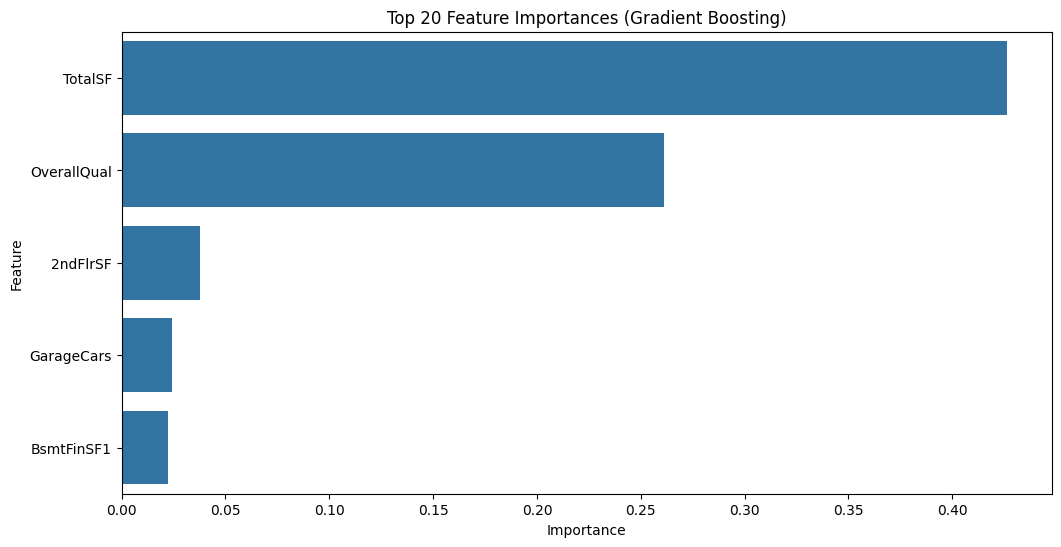

In [59]:
# Feature Importance
final_model.fit(X, y)
importances = final_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(5))  # Top 20 features
plt.title(f'Top 20 Feature Importances ({model_name})')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [60]:
#Step 9: Train Final Model on Full Data
import joblib
final_model.fit(X, y)
# Step 10: Save Final Model

joblib.dump(final_model, f'house_price_{model_name.lower().replace(" ", "_")}_model.pkl')

print("✅ Final model saved successfully!")

✅ Final model saved successfully!


In [66]:
import joblib

test_data = pd.read_csv('test.csv')

#Step 12: Apply Same Feature Engineering
numerical_features_test = test_data.select_dtypes(include=np.number)
test_data[numerical_features_test.columns] = test_data[numerical_features_test.columns].fillna(numerical_features_test.median())
test_data['TotalBathrooms'] = (test_data['FullBath'] + (0.5 * test_data['HalfBath']) +
                                 test_data['BsmtFullBath'] + (0.5 * test_data['BsmtHalfBath']))
test_data['TotalSF'] = (test_data['TotalBsmtSF'] + test_data['1stFlrSF'] + test_data['2ndFlrSF'])
test_data['HouseAge'] = test_data['YrSold'] - test_data['YearBuilt']
test_data['RemodelAge'] = test_data['YrSold'] - test_data['YearRemodAdd']
test_data['IsNewHouse'] = (test_data['YearBuilt'] == test_data['GarageYrBlt']).astype(int)

# One-hot encode
test_data = pd.get_dummies(test_data)
X_test = test_data.reindex(columns=X.columns, fill_value=0)
# Step 13: Load the Saved Model
final_model = joblib.load(f'house_price_{model_name.lower().replace(" ", "_")}_model.pkl')

# Step 14: Make Predictions
#make the id as the index of the prediction
from tqdm import tqdm

predictions = []

for i in tqdm(range(len(X_test)), desc="Predicting"):
    pred = final_model.predict(X_test.iloc[i:i+1])
    predictions.append(pred[0])

predictions = np.array(predictions)

submission = pd.DataFrame({
    'Id': test_data.Id,
    'SalePrice': predictions
})

submission.to_csv('house_price_predictions.csv', index=False)

print("✅ Submission file 'house_price_predictions.csv' created successfully!")

Predicting: 100%|██████████| 1459/1459 [00:11<00:00, 126.31it/s]

✅ Submission file 'house_price_predictions.csv' created successfully!
